### Ribosome ramp

Improved Ribosome-Footprint and mRNA Measurements Provide Insights into Dynamics and Regulation of Yeast Translation

http://www.cell.com/cell-reports/abstract/S2211-1247(16)30021-3

In [50]:
import cPickle as pkl
import numpy as np
import pandas as pd
import shelve
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [51]:
filepath_general = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"
filepath_polysomes = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"

Regular results:

Make file readable by ipython in case it was created by pypy:

In [52]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path, 'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)
    
# replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [53]:
results = pkl.load(open(filepath_general))

In [54]:
print results.keys()

['n_tRNA', 'description', 'n_ribosomes', 'timerange', 'proteome', 'transcriptome', 'duration', 'time_stamp', 'timecourses']


Detailed results/ribosome timecourses:

In [55]:
d = shelve.open(filepath_polysomes)

Generate the ribosome lattice dict (for every gene the total of ribos at all positions):

In [56]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

In [57]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [58]:
pd.Series(avg_ribos_per_gene).describe()

count    4475.000000
mean        0.120880
std         0.573657
min         0.000000
25%         0.007296
50%         0.018478
75%         0.053223
max        12.544326
dtype: float64

Check by means of an example:

In [59]:
print sum(ribo_lattice_dict['YIL140W'])*1.0/len(ribo_lattice_dict['YIL140W'])
print avg_ribos_per_gene['YIL140W']
print np.mean(ribo_lattice_dict['YIL140W'])

0.0109223300971
0.0109223300971
0.0109223300971


#### Analysis of all genes (no count restriction)

Define Weinberg's z (eq. S7):

In [60]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

Test of z:

In [61]:
sum([sum(z[gene]) for gene in z])

2285513.0

In [62]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

6713

In [63]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

Artificially restrict ribo_lattice_dict (for testing):

In [64]:
# ribo_lattice_dict = {key: ribo_lattice_dict[key] for key in ribo_lattice_dict if key in orf_lengths}

Excess ribosome densities:

In [65]:
max_length = max([len(ribo_lattice_dict[gene]) for gene in ribo_lattice_dict])
print max_length

4911


In [66]:
import math

excess = []

for pos in range(max_length):
    
    numer = sum([z[gene][pos] for gene in z if len(ribo_lattice_dict[gene]) > pos])
    denom = sum([1.0          for gene in z if len(ribo_lattice_dict[gene]) > pos])
    # denom = sum([1 if len(ribo_lattice_dict[gene]) > pos else 0 for gene in z]) * 1.0 # daran liegt's nicht
    excess.append(numer / denom)
excess = np.array(excess)

In [67]:
print sum(excess)

4661.09412405


Testing code from previous notebook:

In [68]:
import math

e = []
for j in range(4911):
    numer = 0.0
    denom = 0.0
    for gene in z:
        if orf_lengths[gene]/3 > j:
            if not math.isnan(z[gene][j]):
                numer += z[gene][j]
                denom += 1
        #  denom = sum([1 if orf_lengths[gene] >= j else 0 for gene in ribo_lattice_dict]) * 1.0
    e.append(numer/denom)

In [69]:
sum(e)

4661.0941240543261

Seem to have found the problem; to be continued.

In [70]:
normalization = sum(excess[449:500]) / 51.0
print normalization

1.03143703967


In [71]:
relative_excess = excess / normalization

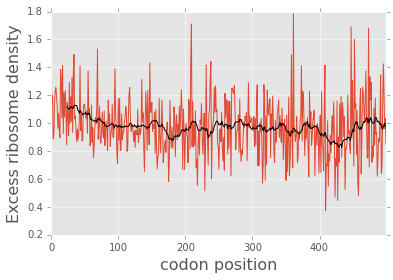

In [72]:
plt.plot(relative_excess[:500])
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(relative_excess[:500]), 25).plot(style='k')

### Restriction to subset of genes

We look at the distribution of ribosomes per ORF before we restrict. 

In [75]:
ribo_total_dict = {gene: sum(ribo_lattice_dict[gene]) 
                   for gene in ribo_lattice_dict}

In [76]:
pd.Series(ribo_total_dict.values()).describe()

count    4475.000000
mean       36.316872
std       180.670141
min         0.000000
25%         3.000000
50%         8.000000
75%        21.000000
max      7075.000000
dtype: float64

In [80]:
len(ribo_total_dict) * np.mean(ribo_total_dict.values())

162518.0

This is approximately the expected number of bound ribosomes (81% of 200000).

In [99]:
critical_count = 128

Weinberg et al. use 128, this would yield 216 genes.

In [100]:
len([gene for gene in ribo_total_dict 
     if ribo_total_dict[gene] >= critical_count])

216

Filter only genes above critical count:

In [101]:
ribo_lattice_dict = {gene: ribo_lattice_dict[gene] for gene in 
                     ribo_lattice_dict if ribo_total_dict[gene] >= 
                     critical_count}

In [102]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [103]:
pd.Series(avg_ribos_per_gene.values()).describe()

count    216.000000
mean       1.656216
std        2.056788
min        0.078563
25%        0.341681
50%        0.654214
75%        2.549656
max       12.544326
dtype: float64

In [104]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

In [105]:
max_length = max([len(ribo_lattice_dict[gene]) for gene in ribo_lattice_dict])
print max_length

2673


In [106]:
import math

excess = []

for pos in range(max_length):
    
    numer = sum([z[gene][pos] for gene in z if len(ribo_lattice_dict[gene]) > pos])
    denom = sum([1.0          for gene in z if len(ribo_lattice_dict[gene]) > pos])
    # denom = sum([1 if len(ribo_lattice_dict[gene]) > pos else 0 for gene in z]) * 1.0 # daran liegt's nicht
    excess.append(numer / denom)
excess = np.array(excess)

In [107]:
print sum(excess)

2482.22264372


In [108]:
normalization = sum(excess[449:500]) / 51.0
print normalization

0.968684460511


In [109]:
relative_excess = excess / normalization

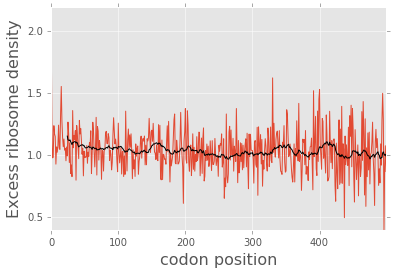

In [110]:
plt.plot(relative_excess[:500])
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(relative_excess[:500]), 25).plot(style='k')

The ribosome ramp has disappeared. TO DO: double check.